# Test Hydra Config

In [9]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf

abs_config_dir = os.path.abspath("config/")

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config = compose(config_name="main.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config)


{'device': 'cpu', 'float_precision': 32, 'budget': 5, 'n_samples': 3, 'seed': 31415, 'maximize': False, 'dataset': {'grid_size': 10, 'normalize_scores': True, 'train_fraction': 1.0, 'batch_size': 16, 'shuffle': True, 'train_path': '${user.data.root}/branin/data_10_train.csv', 'test_path': None, '_target_': 'activelearning.dataset.grid.BraninDatasetHandler'}, 'oracle': {'_target_': 'activelearning.oracle.oracle.BraninOracle', 'fidelity': 1, 'do_domain_map': True}, 'selector': {'_target_': 'activelearning.selector.selector.Selector'}, 'sampler': {'_target_': 'activelearning.sampler.sampler.GreedySampler'}, 'surrogate': {'_target_': 'activelearning.surrogate.gp_surrogate.SingleTaskGPRegressor'}, 'acquisition': {'_target_': 'activelearning.acquisition.acquisition.BOTorchMaxValueEntropyAcquisition', 'acq_fn_class': {'_target_': 'botorch.acquisition.max_value_entropy_search.qLowerBoundMaxValueEntropy', '_partial_': True}}, 'user': {'logdir': {'root': './logs'}, 'data': {'root': './data'}}, '

In [ ]:

dataset = hydra.utils.instantiate(
    config.dataset,
    float_precision=config.float_precision,
)

oracle = hydra.utils.instantiate(
    config.oracle,
    device=config.device,
    float_precision=config.float_precision,
)

surrogate = hydra.utils.instantiate(
    config.surrogate,
    device=config.device,
    float_precision=config.float_precision,
)

acquisition = hydra.utils.instantiate(
    config.acquisition,
    surrogate_model=surrogate,
    dataset_handler=dataset,
    device=config.device,
    float_precision=config.float_precision,
)

sampler = hydra.utils.instantiate(
    config.sampler,
    acquisition=acquisition,
    device=config.device,
    float_precision=config.float_precision,
)

selector = hydra.utils.instantiate(
    config.selector,
    score_fn=acquisition.get_acquisition_values,
    device=config.device,
    float_precision=config.float_precision,
)

{'device': 'cpu', 'float_precision': 32, 'budget': 5, 'n_samples': 3, 'seed': 31415, 'maximize': False, 'dataset': {'grid_size': 10, 'normalize_scores': True, 'train_fraction': 1.0, 'batch_size': 16, 'shuffle': True, 'train_path': '${user.data.root}/branin/data_10_train.csv', 'test_path': None, '_target_': 'activelearning.dataset.grid.BraninDatasetHandler'}, 'oracle': {'_target_': 'activelearning.oracle.oracle.Branin', 'fidelity': 1, 'do_domain_map': True}, 'selector': {'_target_': 'activelearning.selector.selector.Selector'}, 'sampler': {'_target_': 'activelearning.sampler.sampler.GreedySampler'}, 'surrogate': {'_target_': 'activelearning.surrogate.gp_surrogate.SingleTaskGPRegressor'}, 'acquisition': {'_target_': 'activelearning.acquisition.acquisition.BOTorchMaxValueEntropyAcquisition', 'acq_fn_class': {'_target_': 'botorch.acquisition.max_value_entropy_search.qLowerBoundMaxValueEntropy', '_partial_': True}}, 'user': {'logdir': {'root': './logs'}, 'data': {'root': './data'}}, 'logger

### Create Larger Branin Set

In [1]:
from activelearning.dataset.grid import BraninDatasetHandler
from activelearning.oracle.oracle import BraninOracle


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=100,
    train_path="./data/branin/data_%i_train.csv" % 100,
    train_fraction=1.0,
    float_precision=32,
)

candidate_set, xi, yi = dataset_handler.get_candidate_set()

# Oracle
oracle = BraninOracle(
    fidelity=1, do_domain_map=True, device="cpu", float_precision=32
)


In [2]:
# uniform sampling
import numpy as np
subset_idcs = np.random.uniform(0,1,size=(len(candidate_set)))>0.97
subset = candidate_set[subset_idcs]
from activelearning.oracle.oracle import BraninOracle
oracle = BraninOracle(fidelity=1, device="cpu", float_precision=32)

dataset_handler.update_dataset(subset, oracle(subset.clone()), "data/branin/large_branin_100.csv")

(<torch.utils.data.dataloader.DataLoader at 0x7f710c53d630>, None)

In [21]:
# quadrant sampling
import numpy as np
candidate_q1 = candidate_set[(candidate_set[:,0]<0.5) * (candidate_set[:,1]<0.5)]
candidate_q2 = candidate_set[(candidate_set[:,0]<0.5) * (candidate_set[:,1]>=0.5)]
candidate_q3 = candidate_set[(candidate_set[:,0]>=0.5) * (candidate_set[:,1]<0.5)]
candidate_q4 = candidate_set[(candidate_set[:,0]>=0.5) * (candidate_set[:,1]>=0.5)]

subset_idcs_1 = np.random.uniform(0,1,size=(len(candidate_q1)))>0.99
subset_idcs_2 = np.random.uniform(0,1,size=(len(candidate_q1)))>0.99
subset_idcs_3 = np.random.uniform(0,1,size=(len(candidate_q1)))>0.99
subset_idcs_4 = np.random.uniform(0,1,size=(len(candidate_q1)))>1.0

subset_1 = candidate_q1[subset_idcs_1]
subset_2 = candidate_q2[subset_idcs_2]
subset_3 = candidate_q3[subset_idcs_3]
subset_4 = candidate_q4[subset_idcs_4]

import torch
subset = torch.concat([subset_1, subset_2, subset_3, subset_4])
subset.shape

torch.Size([74, 2])

In [22]:
from activelearning.oracle.oracle import BraninOracle
oracle = BraninOracle(fidelity=1, device="cpu", float_precision=32)

dataset_handler.update_dataset(subset, oracle(subset.clone()), "data/branin/large_branin_quadrant_100.csv")

(<torch.utils.data.dataloader.DataLoader at 0x7f8dd0bdd0f0>, None)

# Active Learning Loop

In [5]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf
abs_config_dir = os.path.abspath("config/")

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config = compose(config_name="test_branin.yaml", overrides=[])
    print(OmegaConf.to_yaml(config))
    print(config)

config.sampler.conf.logger.do.online = False

dataset:
  grid_size: 100
  normalize_scores: true
  train_fraction: 1.0
  batch_size: 16
  shuffle: true
  train_path: ~/activelearning/data/branin/data_100_train.csv
  test_path: null
  _target_: activelearning.dataset.grid.BraninDatasetHandler
oracle:
  _target_: activelearning.oracle.oracle.BraninOracle
  fidelity: 1
  do_domain_map: true
sampler:
  _target_: activelearning.sampler.sampler.GreedySampler
  conf:
    agent:
      random_action_prob: 0.0
      optimizer:
        lr: 0.0005
        n_train_steps: 5000
    logger:
      do:
        online: true
      project_name: test_gflownet
      run_name: identity_lr5e-4
    env:
      length: 100
      cell_min: 0
      cell_max: 0.99
      reward_func: power
      reward_min: 1.0e-08
      reward_beta: 1.0
      reward_norm: 1.0
selector:
  _target_: activelearning.selector.selector.Selector
surrogate:
  _target_: activelearning.surrogate.gp_surrogate.SingleTaskGPRegressor
acquisition:
  _target_: activelearning.acquisition.acqui

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'test_branin.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [6]:
import torch
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = config.device
n_iterations = config.budget  # TODO: replace with budget
grid_size = config.dataset.grid_size
n_samples = config.n_samples

from gflownet.utils.common import set_float_precision
float_prec = set_float_precision(config.float_precision)
# float_prec = set_float_precision(32)

import matplotlib.colors as cm
import matplotlib.pyplot as plt
# colors = ["red", "blue", "green", "orange", "brown", "pink"]
colors = plt.get_cmap("Reds")

In [7]:
from activelearning.utils.logger import WandBLogger, ConsoleLogger
logger = WandBLogger(project_name="test_branin", run_name="100_greedy_dkl-30epochs_mve")
# logger = ConsoleLogger(project_name="test_branin", run_name="Greedy 100x100")
# logger = None

from activelearning.utils.plotter import PlotHelper
plotter = PlotHelper(logger)
# plotter = PlotHelper()

best_score,▃▁▁▂▁█▁▂▁▃
mean_topk_score,█▃▂▂▁▁▁▁▁▁
best_score,-290.9906
mean_topk_score,-306.94138


/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/approximate_gp.py:367: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y)
Epoch: 100%|██████████| 30/30 [00:09<00:00,  3.12it/s, loss=1.8] 
/home/mila/c/christina.humer/activelearning/activelearning/utils/plotter.py:73: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.4740]), std = tensor([0.7707])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDa

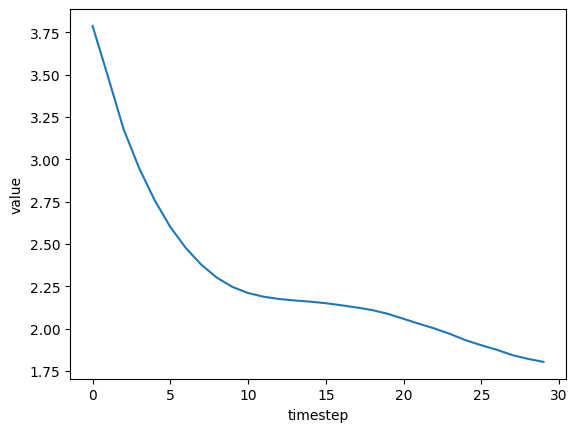

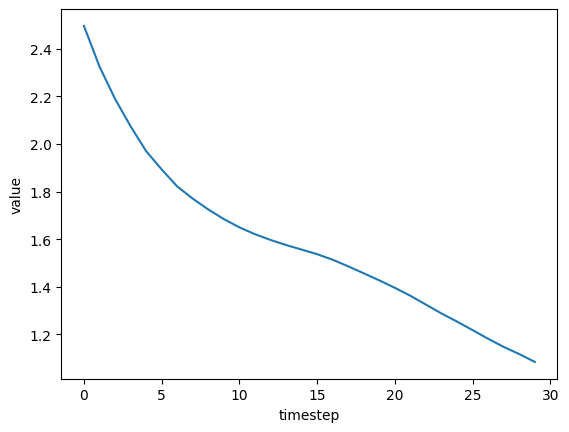

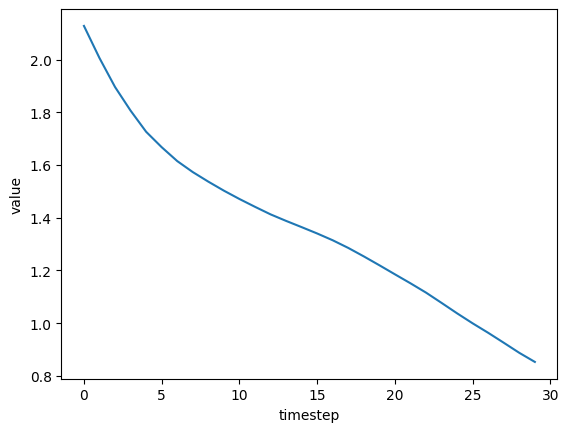

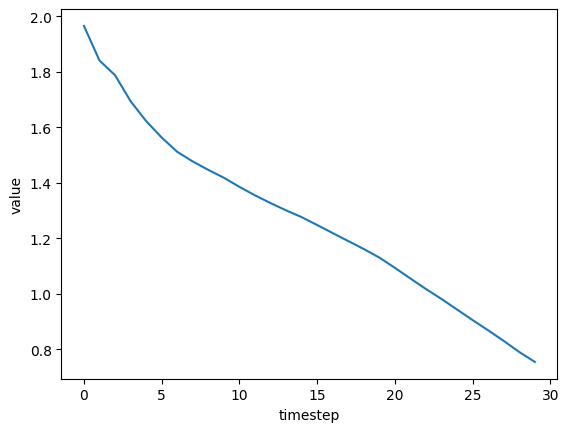

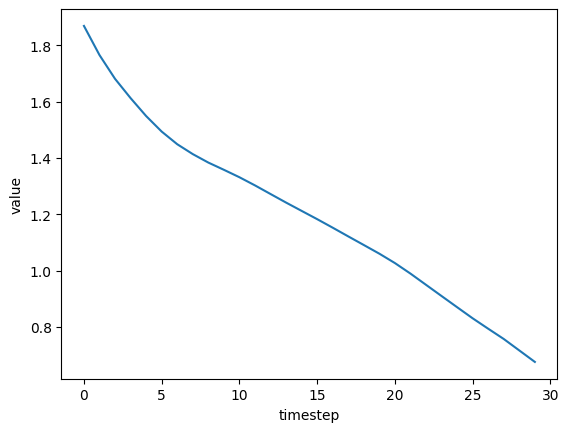

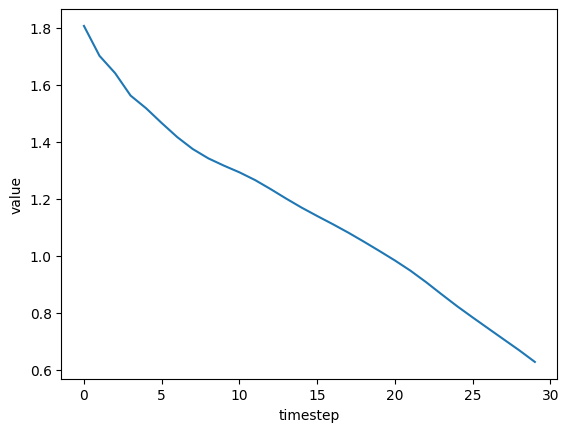

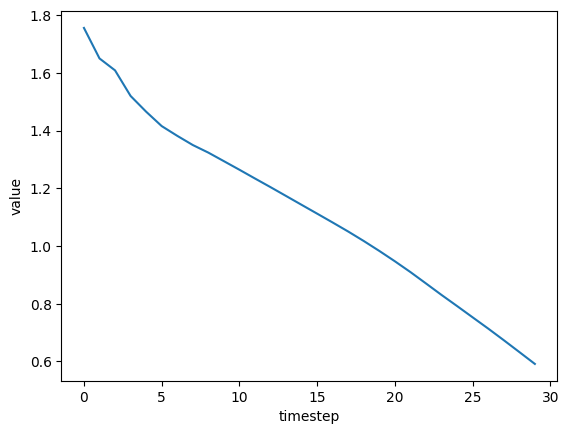

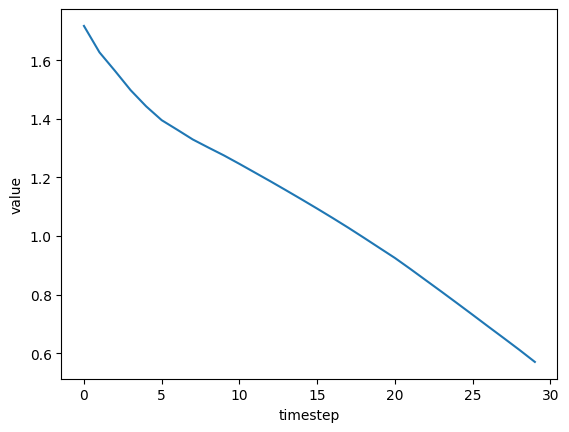

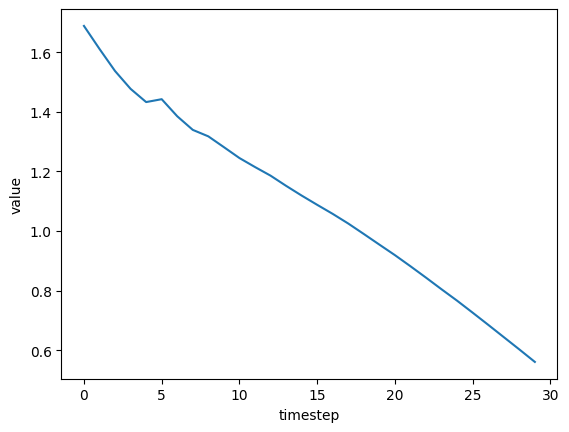

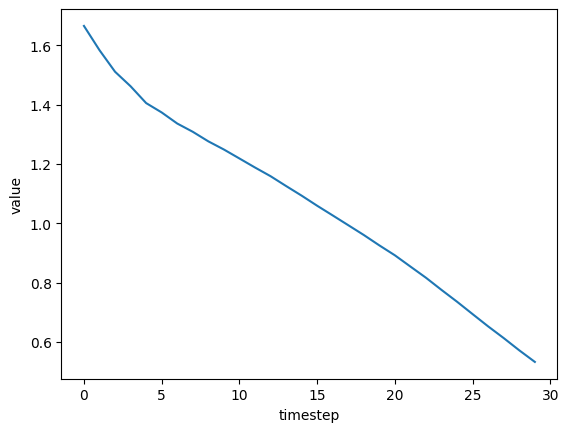

In [8]:
from activelearning.dataset.grid import BraninDatasetHandler
from activelearning.surrogate.gp_surrogate import (
    SingleTaskGPRegressor,
    DeepKernelSVGPSurrogate,
)
from activelearning.acquisition.acquisition import BOTorchMaxValueEntropyAcquisition
from activelearning.sampler.sampler import GreedySampler, RandomSampler
from activelearning.selector.selector import Selector, ScoreSelector
from activelearning.oracle.oracle import BraninOracle
from activelearning.surrogate.feature_extractor.mlp import MLP, Identity


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=grid_size,
    train_path="./data/branin/data_%i_train.csv" % grid_size,
    train_fraction=1.0,
    float_precision=float_prec,
)

candidate_set, xi, yi = dataset_handler.get_candidate_set()

# Oracle
oracle = BraninOracle(
    fidelity=1, do_domain_map=True, device=device, float_precision=float_prec
)

if plotter is not None:
    fig_oracle, ax_oracle = plotter.plot_function(
        oracle, candidate_set.clone().to(device), xi=xi, yi=yi
    )


best_scores = []
all_scores = {}

for i in range(n_iterations):

    train_data, test_data = dataset_handler.get_dataloader()
    # print("iteration", i)
    # Surrogate (e.g., Bayesian Optimization)
    # starts with a clean slate each iteration
    # surrogate = SingleTaskGPRegressor(
    #     device=device,
    #     float_precision=float_prec,
    # )

    # feature_extractor = Identity(2)
    feature_extractor = MLP(
        n_input=2,
        n_hidden=[16, 16],
        n_output=7,
        float_precision=32,
    )
    surrogate = DeepKernelSVGPSurrogate(
        feature_extractor,
        float_precision=float_prec,
        device=device,
        mll_args={"num_data": len(train_data.dataset)},
        train_epochs=30,
        lr=0.1,
        logger=logger,
    )
    surrogate.fit(train_data)

    acq_fn = BOTorchMaxValueEntropyAcquisition(
        surrogate.model, device=device, float_precision=float_prec
    )

    # Sampler (e.g., GFlowNet, or Random Sampler)
    # also starts with a clean slate; TODO: experiment with NOT training from scratch
    sampler = RandomSampler(acq_fn)
    sampler = GreedySampler(
        acq_fn,
        device=device,
        float_precision=float_prec,
    )
    # sampler = hydra.utils.instantiate(
    #     config.sampler,
    #     acquisition=acq_fn,
    #     device=device,
    #     float_precision=float_prec,
    #     _recursive_=False,
    # )

    sampler.fit()  # only necessary for samplers that train a model

    samples, _ = sampler.get_samples(
        n_samples * 5, candidate_set=candidate_set  # .clone().to(device)
    )

    if plotter is not None and hasattr(sampler, "sampler"):

        def reward_fn(samples):
            return sampler.sampler.env.proxy2reward(sampler.sampler.env.proxy(samples))

        fig_reward, ax_reward = plotter.plot_function(
            reward_fn, candidate_set.clone().to(device), xi=xi, yi=yi
        )
        fig_reward, ax_reward = plotter.plot_samples(samples, ax_reward, fig_reward)
        ax_reward.set_title("reward fn + proposed samples of iteration %i" % i)
        plotter.log_figure(fig_reward, "reward")

    # Selector
    selector = Selector(
        device=device,
        float_precision=float_prec,
    )
    # selector = ScoreSelector(
    #     acq_fn,
    #     device=device,
    #     float_precision=float_prec,
    #     maximize=False,
    # )
    filtered_samples, _ = selector(n_samples=n_samples, candidate_set=samples.clone())

    if plotter is not None:
        x, y = train_data.dataset[:]
        fig_surrogate, ax_surrogate = plt.subplots(ncols=2, figsize=(15,7))
        plotter.plot_function(
            surrogate.get_predictions, candidate_set.clone().to(device), xi=xi, yi=yi, output_index=0, fig=fig_surrogate, ax=ax_surrogate[0]
        )
        plotter.plot_samples(x, ax=ax_surrogate[0], fig=fig_surrogate, targets=y*-1)
        ax_surrogate[0].set_title("predicted mean + train data of iteration %i" % i)
        plotter.plot_function(
            surrogate.get_predictions, candidate_set.clone().to(device), xi=xi, yi=yi, output_index=1, fig=fig_surrogate, ax=ax_surrogate[1]
        )
        plotter.plot_samples(x, ax=ax_surrogate[1], fig=fig_surrogate, targets=y*-1)
        ax_surrogate[1].set_title("predicted var + train data of iteration %i" % i)
        plotter.log_figure(fig_surrogate, "surrogate")

    if plotter is not None:
        fig_acq, ax_acq = plotter.plot_function(
            acq_fn, candidate_set.clone().to(device), xi=xi, yi=yi
        )
        fig_acq, ax_acq = plotter.plot_samples(filtered_samples, ax_acq, fig_acq)
        ax_acq.set_title("acquisition fn + selected samples of iteration %i" % i)
        plotter.log_figure(fig_acq, "acq")

    if plotter is not None:
        ax_oracle.scatter(
            x=filtered_samples[:, 1].cpu(),
            y=filtered_samples[:, 0].cpu(),
            c=cm.to_hex(colors(i / n_iterations)),
            marker="x",
            label="it %i" % i,
        )

    scores = oracle(filtered_samples.clone()).cpu()
    dataset_handler.update_dataset(filtered_samples.cpu(), scores)
    best_scores.append(scores.min())
    all_scores[i] = scores
    if logger is not None:
        mean_top_k = torch.stack(list(all_scores.values())).flatten().topk(n_samples, largest=False).values.mean()
        logger.log_metric(mean_top_k, "mean_topk_score")
        logger.log_metric(scores.min(), "best_score")
        logger.log_step(i)

if ax_oracle is not None:
    fig_oracle.legend()
    ax_oracle.set_title("oracle fn + samples")
    plotter.log_figure(fig_oracle, key="oracle")


fig = plt.figure()
plt.plot(best_scores)
plt.xlabel("iterations")
plt.ylabel("scores")
plt.title("Best Score in each iteration")
if plotter is not None:
    plotter.log_figure(fig, key="best_scores")

# Test individual components

In [ ]:
import os

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)


from gflownet.utils.common import set_float_precision
float_prec = set_float_precision(64)
# float_prec = torch.double

import numpy as np
grid_size = 10  # 100
test_states = torch.tensor([[0.5, 0.5]])
test_scores = torch.tensor([-150.0])
n_samples = 5

baseline_states = torch.tensor(
    [
        [0.0 * grid_size, 0.0 * grid_size],
        [0.0 * grid_size, 0.4 * grid_size],
        [0.4 * grid_size, 0.0 * grid_size],
        [0.8 * grid_size, 0.8 * grid_size],
    ]
)

# define grid space
xi = np.arange(0, 1, 1 / grid_size)
yi = np.arange(0, 1, 1 / grid_size)
grid = np.array(np.meshgrid(xi, yi))
grid_flat = torch.tensor(grid.T, dtype=float_prec).reshape(-1, 2).to(device)

In [ ]:
# dataset
from dataset.dataset import BraninDatasetHandler

dataset_handler = BraninDatasetHandler(
    grid_size=grid_size,
    train_path="./storage/branin/data_%i_train.csv" % grid_size,
    train_fraction=1.0,
    float_precision=float_prec,
)

# testing dataset
dataset_handler.update_dataset(test_states, test_scores)
print(dataset_handler.train_data.X_data, dataset_handler.train_data.y_data)
print(dataset_handler.train_data[:])
train_loader, test_loader = dataset_handler.get_dataloader()
for X, y in train_loader:
    print(X, y)

In [ ]:
# Oracle
from gflownet.proxy.box.branin import Branin

oracle = Branin(fidelity=1, do_domain_map=True, device=device, float_precision=float_prec)

# testing oracle
print(oracle(baseline_states.to(device).clone() / grid_size))

# plot oracle function
plot_function(oracle, grid_flat.clone(), scatter_markers=baseline_states / grid_size)
plt.title("Oracle function")
plt.show()

In [ ]:
# Surrogate (e.g., Bayesian Optimization)
from surrogate.surrogate import SingleTaskGPRegressor

surrogate = SingleTaskGPRegressor(device=device, float_precision=float_prec)
train_data, test_data = dataset_handler.get_dataloader()
surrogate.fit(train_data)

# testing surrogate
preds_mean, preds_var = surrogate.get_predictions(test_states / grid_size)
print(preds_mean, preds_var)

# plot surrogate functions
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

plot_function(
    surrogate.get_predictions,
    grid_flat.clone(),
    fig=fig,
    ax=axes[0],
    scatter_markers=baseline_states / grid_size,
    output_index=0,
)
axes[0].set_title("estimated mean")

plot_function(
    surrogate.get_predictions,
    grid_flat.clone(),
    fig=fig,
    ax=axes[1],
    scatter_markers=baseline_states / grid_size,
    output_index=1,
)
axes[1].set_title("uncertainty")

plot_function(
    surrogate.get_acquisition_values,
    grid_flat.clone(),
    fig=fig,
    ax=axes[2],
    scatter_markers=baseline_states / grid_size,
)
axes[2].set_title("acquisition function")

fig.suptitle("Surrogate Model")
plt.show()

In [ ]:
# Sampler (e.g., GFlowNet, or Random Sampler)
from sampler.sampler import GreedySampler, RandomSampler

sampler = GreedySampler(surrogate)
# sampler = RandomSampler(surrogate)
sampler.fit()
samples, _ = sampler.get_samples(n_samples * 3, grid_flat.clone()).cpu()

# plot acq function with proposed candidates
fig, ax = plot_function(
    surrogate.get_acquisition_values, grid_flat.clone(), scatter_markers=samples
)
plt.title("Samples")
plt.show()

In [ ]:
acq = surrogate.get_acquisition_values(grid_flat.clone()).detach().cpu()
plt.matshow(acq.reshape(int(len(acq) ** (1 / 2)), int(len(acq) ** (1 / 2))))
plt.scatter(samples.cpu()[:, 1] * grid_size, samples.cpu()[:, 0] * grid_size)
plt.scatter(baseline_states[:, 1].cpu(), baseline_states[:, 0].cpu())

In [ ]:
from filter.filter import Filter, ScoreFilter

filter = Filter()
# filter = OracleFilter(oracle)
filtered_samples = filter(n_samples, samples)

# plot oracle function with proposed candidates
fig, ax = plot_function(
    surrogate.get_acquisition_values,
    grid_flat.clone(),
    scatter_markers=filtered_samples.to("cpu"),
)
plt.title("Proposed Candidates")
plt.show()

# GFlowNet Sampler

In [ ]:
import torch
float_prec = torch.float32
device = "cpu"
grid_size = 10

In [ ]:
# dataset
from dataset.dataset import BraninDatasetHandler

dataset_handler = BraninDatasetHandler(
    grid_size=grid_size,
    train_path="./storage/branin/data_%i_train.csv" % grid_size,
    train_fraction=1.0,
    float_precision=float_prec,
)


In [ ]:
train_data, _ = dataset_handler.get_dataloader()
for r in train_data:
    print(r)

In [ ]:
from importlib import reload  # Python 3.4+
import surrogate.surrogate as surrogate

reload(surrogate)

from surrogate.surrogate import SingleTaskGPRegressor

surrogate = SingleTaskGPRegressor(device=device, float_precision=float_prec, maximize=False)
train_data, test_data = dataset_handler.get_dataloader()
surrogate.fit(train_data)

In [ ]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf

abs_config_dir = os.path.abspath("config/")


In [ ]:
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_logger = compose(config_name="logger/wandb.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_logger)

logger = hydra.utils.instantiate(config_logger.logger, config_logger, _recursive_=False)

In [ ]:
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_logger = compose(config_name="logger/wandb.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_logger)

# Logger
# from utils.logger import Logger

# logger = Logger(config=OmegaConf.create(), **config_logger)
logger = hydra.utils.instantiate(config_logger.logger, config_logger, _recursive_=False)

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_sampler = compose(config_name="sampler/gflownet.yaml", overrides=[])
    # print(OmegaConf.to_yaml(config_sampler))
    print(config_sampler)

grid_env = hydra.utils.instantiate(
    config_sampler.sampler.conf.env,
    proxy=surrogate,
    device=device,
    float_precision=float_prec,
)

# The policy is used to model the probability of a forward/backward action
forward_policy = hydra.utils.instantiate(
    config_sampler.sampler.conf.policy.forward,
    env=grid_env,
    device=device,
    float_precision=float_prec,
)
backward_policy = hydra.utils.instantiate(
    config_sampler.sampler.conf.policy.backward,
    env=grid_env,
    device=device,
    float_precision=float_prec,
)

# State flow
if config_sampler.sampler.conf.state_flow is not None:
    state_flow = hydra.utils.instantiate(
        config_sampler.sampler.conf.state_flow,
        env=grid_env,
        device=device,
        float_precision=float_prec,
        base=forward_policy,
    )
else:
    state_flow = None

# GFlowNet Agent
sampler = hydra.utils.instantiate(
    config_sampler.sampler.conf.agent,
    device=device,
    float_precision=float_prec,
    env=grid_env,
    forward_policy=forward_policy,
    backward_policy=backward_policy,
    state_flow=state_flow,
    buffer=config_sampler.sampler.conf.env.buffer,
    logger=logger,
)

In [ ]:
sampler.train()

In [ ]:
batch, times = sampler.sample_batch(n_forward=10, train=False)

In [ ]:
batch.get_terminating_states(proxy=True)

In [ ]:
sampler

In [ ]:
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_sampler = compose(config_name="sampler/gflownet.yaml", overrides=[])
    # print(OmegaConf.to_yaml(config_sampler))
    print(config_sampler)
    
sampler = hydra.utils.instantiate(
    config_sampler.sampler,
    surrogate=surrogate,
    logger=logger,
    device=device,
    float_precision=float_prec,
)


In [ ]:
samples, _ = sampler.get_samples(n_samples * 3, grid_flat.clone()).cpu()

# plot acq function with proposed candidates
fig, ax = plot_function(
    surrogate.get_acquisition_values, grid_flat.clone(), scatter_markers=samples
)
plt.title("Samples")
plt.show()

In [ ]:
from sampler.sampler import GFlowNetSampler

sampler = GFlowNetSampler(surrogate, config_sampler, logger, device, float_prec)

In [ ]:

# Logger
# from utils.logger import Logger

# logger = Logger(config=OmegaConf.create(), **config_logger)

In [ ]:
from gflownet.envs.grid import Grid as GFlowNetGridEnv

grid_env = GFlowNetGridEnv(
    n_dim=2,
    length=grid_size,
    max_increment=1,
    max_dim_per_action=1,
    cell_min=0,
    cell_max=1,
    proxy=surrogate,
    reward_func="identity",
)

In [ ]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf

abs_config_dir = os.path.abspath("config/")
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_gflownet = compose(config_name="gflownet.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_gflownet)

# GFlowNetAgent
from gflownet.policy.base import Policy
from gflownet.gflownet import GFlowNetAgent

forward_policy = Policy(
    config_gflownet.policy.forward,
    env=grid_env,
    device=device,
    float_precision=torch.double,
)

backward_policy = Policy(
    config_gflownet.policy.backward,
    env=grid_env,
    device=device,
    float_precision=torch.double,
)

sampler = GFlowNetAgent(
    grid_env,
    device=device,
    float_precision=torch.double,
    forward_policy=forward_policy,
    backward_policy=backward_policy,
    logger=logger,
    **config_gflownet
)

In [ ]:
sampler.train()

In [ ]:
from gflownet.utils.batch import Batch
batch = Batch(env=grid_env, device=device, float_type=float_prec)

In [ ]:
# Make indices of batch consecutive since they are used for indexing here
# Get necessary tensors from batch
states_policy = batch.get_states(policy=True)
states = batch.get_states(policy=False)
actions = batch.get_actions()
parents_policy = batch.get_parents(policy=True)
parents = batch.get_parents(policy=False)
traj_indices = batch.get_trajectory_indices(consecutive=True)
# Forward trajectories
masks_f = batch.get_masks_forward(of_parents=True)
policy_output_f = forward_policy(parents_policy)

In [ ]:
# # environment
# import config
# train = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# test = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# buffer = config.env.Buffer(train=train, test=test)
# config_env = config.env.Grid_Env(
#     buffer,
#     min_step_len=1,
#     max_step_len=1,
#     cell_min=-1,
#     cell_max=1
# )

# from environment.grid_env import GridEnv
# env = GridEnv(**config_env.__dict__)